# MBA FIAP Inteligência Artificial & Machine Learning

## Visão Computacional: Análise de Vivacidade

> Atenção: este notebook foi desenhado para funcionar no **Google Collab**.


## 1. Introdução

Uma determinada fintech focada em consumidores finais pessoa física constataou um grande número de fraudes em transações bancárias.

O setor de fraudes apontou que existem clientes que se queixaram de não contratar serviços específicos, como o crédito pessoal, e após isso transferir para outras contas desconhecidas. 

Após análises pelas equipes de segurança, os protocolos de utilização da senha foram realizados em conformidade, ou seja, cada cliente autenticou com sua própria senha de maneira regular.

Em função disso, o banco precisa arcar com reembolsos e medidas de contenção para evitar processos judiciais, pois os clientes alegam terem sido invadidos por hackers ou algo parecido.

Uma das formas de solucionar ou minimizar este problema é com a utilização de outras formas de autenticação, sobretudo em operações críticas, como a obtenção de crédito pessoal.

Desta forma podemos implementar uma verificação de identidade com prova de vida (liveness), que utilize uma verificação e identificação facial. 

Caso o cliente não seja autenticado, ele será atendido por uma esteira dedicada e as evidências da não identificação serão encaminhadas para a área de IA para validação dos parâmetros e limiares para aperfeiçoamento do modelo.

Será necessário construir:

* Detector de faces
* Identificação de faces (podendo ser um comparador entre um rosto de documento e outra da prova de vida)
* Detecção de vivacidade (liveness) para evitar que um fraudador utilize uma foto estática.


>Formas alternativas de prover a identificação e prova de vivacidade, além destas que foram solicitadas poderão ser submetidas.

Imagem retirada do [Grunge](https://www.grunge.com/192826/company-testing-robocop-facial-recognition-software-with-us-police/).

## 2. Instruções

Este projeto final tem como objetivo explorar os conhecimentos adquiridos nas aulas práticas.

Iremos constuir uma forma de validar se uma determinada imagem foi ou não adulterada e se trata de uma produção fraudade.

Existem diversas formas de validar a vivacidade, e neste sentido conto com a criatividade de vocês dado que já dominam encontrar uma face numa imagem, aplicar marcos faciais e até mesmo construir uma rede neural convulacional.

A abordagem mais simples é pela construção de uma rede neural com imagens de fotos de rostos de outras fotos e fotos de rostos sem modificações. Tal classificador deverá classificar se dada imagem possui vivacidade ou não com uma pontuação de probabilidade.

Referências que abordam o tema para servir de inspiração:

1. [PyImageSearch](https://pyimagesearch.com/2019/03/11/liveness-detection-with-opencv/), Liveness detection with OpenCV;
2. [Kickertech](https://kickertech.com/face-liveness-detection-via-opencv-and-tensorflow/), Liveness detection via OpenCV and Tensorflow.
3. [Towards Data Science](https://towardsdatascience.com/real-time-face-liveness-detection-with-python-keras-and-opencv-c35dc70dafd3?gi=24f8e1b740f9), Real-time face liveness detection with Python, Keras and OpenCV.

Este projeto poderá ser feita por grupos de até 4 pessoas.
Caso este projeto seja substitutivo, deverá ser realizado por apenas uma pessoa.

| Nome dos Integrantes     | RM            | Turma |
| :----------------------- | :------------- | :-----: |
| Albert Mazuz             | RM 349663      | 4DTS |
| Otavio Augusto           | RM 350448      | 4DTS |
| Pedro Augusto Ferreira   | RM 348801      | 4DTS |
| William Reis de Araujo   | RM 348868      | 4DTS |

## 3. Abordagem e organização da solução do problema (2 pontos)

Como o grupo pretende deteccar a prova de vivacidade de uma determinada imagem? Quais os passos e os building blocks deste processo?

**Resposta**: 
Vamos criar uma rede neural convulocional a partir da base de dados fornecida pela NUAA. Ela contem imagens de fotos reais de usuários e de tentativas de ataque através de fotos impressas.

http://parnec.nuaa.edu.cn/_upload/tpl/02/db/731/template731/pages/xtan/NUAAImposterDB_download.html

## 4 Desenvolvimento da solução (5,5 pontos)

Detalhe o passo-a-passo do algoritmo de deteção de vivacidade.
Se optar pela construção e treinamento de um modelo de redes neurais convulucionais, apresente a arquitetura, prepare os dados de treinamento, realize o treinamento.

### 4.1 Organização de dados para treinamento de modelo de liveness (2 pontos)

In [1]:
# from ..tools import functions
from tools import functions
from tools import connection as conns

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential,load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, AveragePooling2D,Activation
from keras.utils import plot_model
from keras.utils import  to_categorical
from keras.layers import BatchNormalization
from PIL import Image
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from imutils import paths
import pickle
import cv2
import os
%matplotlib inline

### Separando imagens do banco Nuua em pastas de Clientes e fakes

In [14]:

## Comentado pois já foi executado
# import os
# ### Preparando imagens e salvando nas pastas
# tipos=['Client','Imposter']
# i=0
# for tipo in tipos:
#     folder_path=f'dados//preparados//{tipo}//'
#     for client in os.listdir(f'dados//raw//{tipo}Raw'):
#         for img_name in os.listdir(f'dados//raw//{tipo}Raw//{client}'):
#             file_path=f'dados//raw//{tipo}Raw//{client}//{img_name}'

#             if os.path.splitext(file_path)[1].lower() == '.jpg':
#                 # print(file_path)
#                 img=Image.open(f'dados//raw//{tipo}Raw//{client}//{img_name}')
#                 img_prep=crop(img)
#                 filename=tipo+'_'+str(i)+'.jpg'
#                 destination_path=os.path.join(folder_path, filename)
#                 # print(destination_path)                     
#                 img_prep.save(destination_path)
#                 i+=1       
            



### Crop de imagens no ROI e salva em dados/deteccaoLiveness/ROI

In [56]:
import os
tipos=['Client','Imposter']
# tipos=['Imposter']
for tipo in tipos:
    print(f'Iniciando {tipo}' )
    destination_folder_path=f'dados//deteccaoLiveness//ROI//{tipo}//'
    origin_folder_path=f'dados//deteccaoLiveness//preparados//{tipo}'
    for img_name in tqdm(os.listdir(origin_folder_path)):  
        if img_name not in os.listdir(destination_folder_path):
            try:
                img_path=f'{origin_folder_path}//{img_name}'
                #Get Bounding Box
                top,left,width,height= functions.get_bounding_box(img_path)
                #Get images 
                image = Image.open(img_path) 
                #Crop Image
                cropped_image=functions.crop_image(image,top,left,width,height)
                #Save Image
                # print(img_path)
                cropped_image.save(f'{destination_folder_path}//{img_name}')
            except Exception as e:
                pass



Iniciando Client


 36%|███▌      | 353/976 [12:31<29:23,  2.83s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x0000016E2AFA60D0>>
Traceback (most recent call last):
  File "c:\Users\alber\Documents\Projetos - Dados\fiap_cognitive_enviroment_liveness\.venv\Lib\site-packages\ipykernel\ipkernel.py", line 801, in _clean_thread_parent_frames
    for identity in list(thread_to_parent.keys()):
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt: 
 37%|███▋      | 359/976 [12:44<21:19,  2.07s/it]

### 4.2 Treinamento de modelo de liveness (1,5 pontos)

#### Construindo o Modelo

In [3]:
model=Sequential()
inputShape=(32,32,3)
chanDim=-1
classes=2




# first CONV => RELU => CONV => RELU => POOL layer set
model.add(Conv2D(16, (3, 3), padding="same",
    input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(16, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# second CONV => RELU => CONV => RELU => POOL layer set
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# first (and only) set of FC => RELU layers
model.add(Flatten())
model.add(Dense(64))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
# softmax classifier
model.add(Dense(classes))
model.add(Activation("softmax"))



c:\Users\alber\Documents\Projetos - Dados\fiap_cognitive_enviroment_liveness\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 148,562 (580.32 KB)

 Trainable params: 148,242 (579.07 KB)

 Non-trainable params: 320 (1.25 KB)

#### Construindo Data Set

In [4]:
labels=[]
data=[]

tipos=['Client','Imposter']
for tipo in tipos:
    origin_folder_path=f'dados//deteccaoLiveness//ROI//{tipo}'
    #Define o label para cada classe 1 é cliente , 0 é fraude 
    if tipo=='Client': label=1
    else: label=0
    #Muda o tamanho da imagem para 32x32
    for img_name in os.listdir(origin_folder_path):
        img_path=f'{origin_folder_path}//{img_name}'
        img=cv2.imread(img_path)
        img=cv2.resize(img,(32,32))
        data.append(img)
        labels.append(label)



data = np.array(data, dtype="float") / 255.0

In [5]:
# one-hot encode them
le = LabelEncoder()
labels = le.fit_transform(labels)
labels = to_categorical(labels, 2)





In [6]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.25, random_state=42,stratify=labels)

In [7]:
INIT_LR=1e-4
BS=8
EPOCHS=30



# construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
	width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
	horizontal_flip=True, fill_mode="nearest")

# initialize the optimizer and model
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)


model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the network
print("[INFO] training network for {} epochs...".format(EPOCHS))
# H = model.fit(trainX,trainY, validation_data=(testX, testY),epochs=EPOCHS)


#Treina com dados sintéticos
H = model.fit(x=aug.flow(trainX, trainY, batch_size=BS),
	validation_data=(testX, testY), steps_per_epoch=len(trainX) // BS,
	epochs=EPOCHS)


c:\Users\alber\Documents\Projetos - Dados\fiap_cognitive_enviroment_liveness\.venv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


[INFO] training network for 30 epochs...


Epoch 1/30


c:\Users\alber\Documents\Projetos - Dados\fiap_cognitive_enviroment_liveness\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


109/109 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.6750 - loss: 0.7360 - val_accuracy: 0.6507 - val_loss: 0.6459
Epoch 2/30
  1/109 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 0.1010

C:\Users\alber\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0510 - val_accuracy: 0.6507 - val_loss: 0.6466
Epoch 3/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.9327 - loss: 0.2458 - val_accuracy: 0.6507 - val_loss: 0.5286
Epoch 4/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0548 - val_accuracy: 0.6507 - val_loss: 0.5258
Epoch 5/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9708 - loss: 0.1419 - val_accuracy: 0.9452 - val_loss: 0.1992
Epoch 6/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0345 - val_accuracy: 0.9521 - val_loss: 0.1952
Epoch 7/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9743 - loss: 0.1159 - val_accuracy: 1.0000 - val_loss: 0.0525
Epoch 8/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3750 - loss: 0.9170 - val_accuracy: 1.0000 - val_loss: 0.0522
Epoch 9/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9801 - loss: 0.1005 - val_accuracy: 1.0000 - 

### 4.3 Métricas de desempenho do modelo (2 pontos)

In [47]:
predictions = model.predict(x=testX, batch_size=BS)


423/423 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [48]:
print(classification_report(testY.argmax(axis=1),predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1979
           1       0.99      1.00      1.00      1398

    accuracy                           1.00      3377
   macro avg       1.00      1.00      1.00      3377
weighted avg       1.00      1.00      1.00      3377



### Salvando o modelo

In [49]:
model_json = model.to_json()
with open("modelos//fraud_detector_v01.json", "w") as json_file:
    json_file.write(model_json)
# Salvando os pesos do modelo em HDF5
model.save("modelos/fraud_detector_v01.keras")

## 5 Teste Fim-a-Fim

Simule a operação fim-a-fim, com uma imagem de entrada forjada (foto de foto de um rosto) e outra com uma imagem de rosto, exibindo o resultado da classificação e a pontuação de cada classe.

client.jpg


imposter.jpg
temp2.jpg


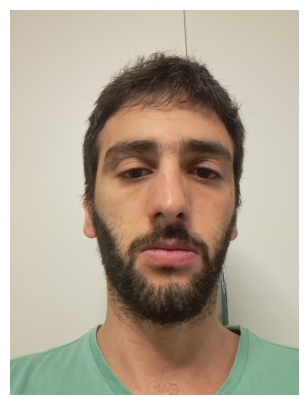

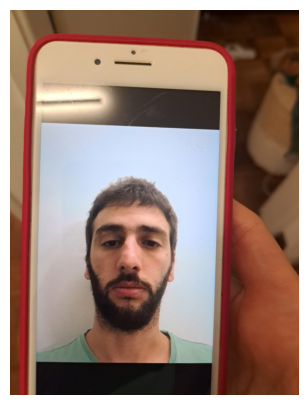

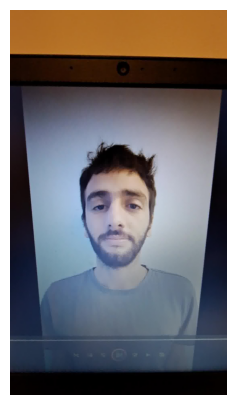

In [8]:
#IMPLEMENTAR

data=[]
imgs_img=[]

folder_path=r'C:\Users\alber\Documents\Projetos - Dados\fiap_cognitive_enviroment_liveness\dados\deteccaoLiveness\teste'
imgs=['client.jpg','imposter.jpg','temp2.jpg']
for img_name in imgs:
    print(img_name)
    img_path=f'{folder_path}//{img_name}'
    #Get BoundingBOx
    top,left,width,height= functions.get_bounding_box(img_path)
    #Plot Image
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(5,5))
    plt.axis('off')
    plt.imshow(img)
    #Get image 
    img = Image.open(img_path) 
    #Crop Image
    cropped_image=functions.crop_image(img,top,left,width,height)
    #save imagem
    temp_path=f'{folder_path}//temp.jpg'
    cropped_image.save(temp_path)
    #Prepare Image
    img=cv2.imread(temp_path)
    img=cv2.resize(img,(32,32))
    #Add image to list
    data.append(img)
#Prepara data
data= np.array(data, dtype="float") / 255.0


In [9]:
BS=8
predictions = model.predict(x=data, batch_size=BS)
for prediction in predictions:
    if prediction.argmax(axis=0)==1:
        print(f'Imagem é verdadeira. Prob = {prediction[1]}')
    else:
        print(f'Imagem é falsa. Prob = {prediction[0]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
Imagem é verdadeira. Prob = 0.9997486472129822
Imagem é falsa. Prob = 1.0
Imagem é falsa. Prob = 1.0


### 5.2 Lendo a partir de arquivo bytes e modelo carregado

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step
[[2.8929227e-07 9.9999976e-01]
 [2.1091266e-07 9.9999976e-01]
 [9.9999988e-01 1.5528433e-07]]
Imagem é verdadeira. Prob = 0.9999997615814209
Imagem é verdadeira. Prob = 0.9999997615814209
Imagem é falsa. Prob = 0.9999998807907104


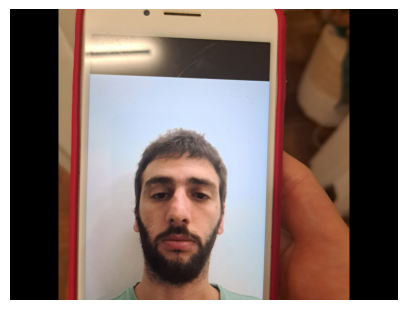

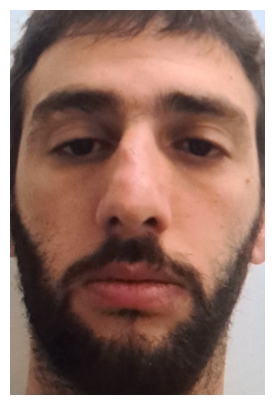

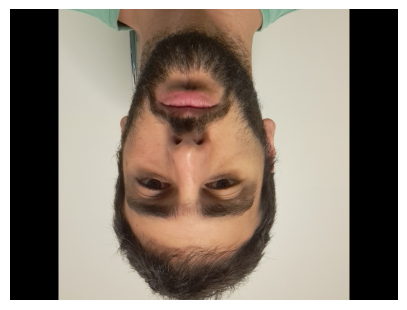

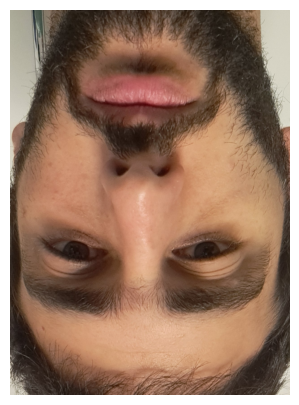

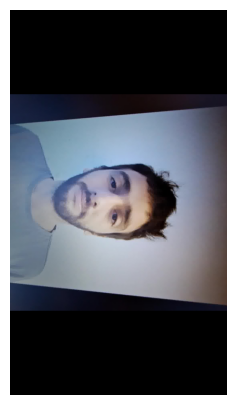

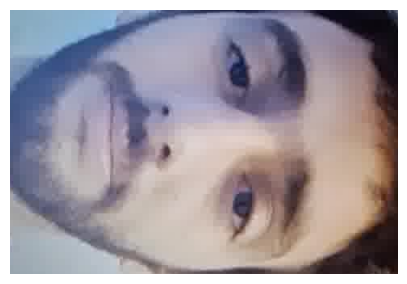

In [11]:
import io
#Origem
# file_path=r'C:\Users\alber\Documents\Projetos - Dados\fiap_cognitive_enviroment_liveness\dados\deteccaoLiveness\teste\imposter.jpg'
#Carrega o Modelo
model=tf.keras.models.load_model('modelos/fraud_detector_v01.keras')

file_paths=[r'C:\Users\alber\Documents\Projetos - Dados\fiap_cognitive_enviroment_liveness\dados\deteccaoLiveness\teste\imposter.jpg',
            r'C:\Users\alber\Documents\Projetos - Dados\fiap_cognitive_enviroment_liveness\dados\deteccaoLiveness\teste\temp2.jpg']
data=[]

for file_path in file_paths:
    #Carrega imagem como Bytes
    with open(file_path, 'rb') as f:
        bytes_file = f.read()

    temp_path=r"C:\Users\alber\Documents\Projetos - Dados\fiap_cognitive_enviroment_liveness\dados\deteccaoLiveness\teste\temp.jpg"

    #Carrega imagem como Image
    img = Image.open(io.BytesIO(bytes_file))
    img=img.rotate(-90)
    img.save(temp_path)

    plt.figure(figsize=(5,5))
    plt.axis('off')
    plt.imshow(img)

    top,left,width,height= functions.get_bounding_box(temp_path)
    #Crop Image
    cropped_image=functions.crop_image(img,top,left,width,height)
    #save image
    cropped_image.save(temp_path)

    plt.figure(figsize=(5,5))
    plt.axis('off')
    plt.imshow(cropped_image)

    #Prepare Image
    img = Image.open(temp_path) 
    img=cv2.imread(temp_path)
    img=cv2.resize(img,(32,32))


    #Add image to list
    data.append(img)


data= np.array(data, dtype="float") / 255.0
predictions = model.predict(x=data, batch_size=BS)
print(predictions)
for prediction in predictions:
    if prediction.argmax(axis=0)==1:
        print(f'Imagem é verdadeira. Prob = {prediction[1]}')
    else:
        print(f'Imagem é falsa. Prob = {prediction[0]}')







>Com a implementação da solução na forma de uma aplicação do [Streamlit](https://www.streamlit.io/) (veja a pata streamlit-app e use o template) vale 1 ponto adicional.

**Pergunta**: Se utilizou o Streamlit, compartilhe a URL do aplicativo publicado:

**Resposta**: https://fiap-cognitive-enviroment-liveness-4dts.streamlit.app/

## 6 Conclusões (2,5 pontos)

**Pergunta**: Dado todo o estudo e pesquisa, quais foram as conclusões sobre a solução, o que funcionou, o que não funcionou e quais os detalhes que observariam numa nova versão e melhorias do processo?

**Resposta**:
O algoritmo de detecção apesar de ter indicadores de teste com acurácia de 100% tem alguns problemas

* Dataset com volume pequeno que não pode ser compensado com o uso de dados sintéticos.
* Resultados em produção inconsistente com o os dados de treinamento e teste

Em um ambiente de negócios esses aspectos devem ser considerados e propomos as seguintes soluções:
* Criação de um dataset de qualidade com representação significativa de todos os tipos de fraudes possíveis (imagem impressa, imagem digital, modelo 3d)
* Averiguação dos problemas em produção. Verificar se a causa é o overfit ou alguma alteração dos dados no processo de obtenção das imagens.